In [1]:
'''Calculates SVD of cleaned EEG
requires cleaned files (segment_edit)'''
from hdf5storage import loadmat, savemat
import numpy as np
from matplotlib import pyplot as plt
from hnlpy.timeop import baselinecorrect
from hnlpy.timeop import makefiltersos
import scipy.signal as signal



In [2]:
def avref(datax,bchan=[]):
	""" Assumes datax is time by channels"""
	nchan = np.shape(datax)[1]
	gchan = np.setdiff1d(range(nchan),bchan)
	ref = np.mean(datax[:,gchan],axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	if len(bchan) != 0:
		datax[:,bchan] = 0
	return datax

In [3]:
sub = '130'
ses = '3'
take_ends = False
path = f'cleaned/{sub}SS{ses}_cleaned.hdf.mat'
data = loadmat(path)


In [4]:
data.keys()

dict_keys(['answer', 'block', 'channel_labels', 'channel_location', 'choice', 'eeg', 'failed_channels', 'filter', 'icastat', 'model_response', 'ordered_features', 'position', 'responsetime', 'samplingrate', 'time', 'trial', 'use_channels'])

In [5]:
#unpack the dictionary for behavioral analysis 
answer = data['answer']
#cedrus = data['cedrus_response']
choice = data['choice'].astype(int)
good_trials = data['icastat']['good_trials']
of = data['ordered_features']
responsetime = data['responsetime']
#unpack the dictionary for erp analysis 
eeg = data['eeg']
failed_channels = data['failed_channels']
#this is a temporary fix, hopefully it can be corrected tomorrow
#THIS SHOULD BE REMOVED ONCE THE FILE IS FIXED
#for j in range(np.shape(eeg_1)[0]):
#	trial = eeg_1[j,:,:]
#	trial = avref(trial,failed_channels)
#	eeg_1[j,:,:] = trial 
#eeg = np.zeros((1950,np.shape(eeg_1)[1],np.shape(eeg_1)[2]))
#eeg[eegtrials,:,:] = eeg_1
#THIS SHOULD BE REMOVED ONCE FILE IS FIXED 

channel_labels = data['channel_labels']
channel_localtion = data['channel_location']
#good_trials = data['good_trials']
position = data['position']
sr = data['samplingrate']
time = data['time']
use_channels = data['use_channels']
trial = data['trial']





Next block of code does some handling of the stimulus sequences and their labels.  This needs to be validated by Shane against his original cvs files. 

Here i make separate list of the stimulus type and the stimulus value for each stimulus.  Every 10th one should be the response cue.  

In [6]:
stimtype = list()
stimval = list()
for j in range(len(of)):
	x = of[j].split(':')
	if len(x) == 2:
		stimtype.append(x[0])
		if x[0] == 'Age':
			x[1] = int(x[1])
		elif x[0] == 'Hours per Week':
			x[1] = int(x[1])
		else:
			x[1] = x[1][1:]
		stimval.append(x[1])
	else:
		stimtype.append(x[0])
		stimval.append(x[0])


Here i extract the unique value of the stimtype as the feature_list.  then, I also extract all the unique feature values.  For my convenience, what I do next is to make a numerical version of stimtype, which i can stim_index.  
Then I make a couple of arrays to identify which features are categorical (versus numerical).  I also make one to keep track of the fact that the response cue is not a feature, but is an eeg stimulus.  

In [7]:

feature_list = list(np.unique(stimtype))
feature_values = dict()
for j in feature_list:
	feature_values[j] = list()
for j in range(len(stimval)):
	feature_values[stimtype[j]].append(stimval[j])
for j in feature_list: 
	feature_values[j] = list(np.unique(feature_values[j]))  
stim_index = np.zeros(len(stimtype))
for j in range(len(stimtype)):
	stim_index[j] = np.where(np.array(feature_list) == stimtype[j])[0]
feature_categorical = np.ones(10)
feature_categorical[0] = 0
feature_categorical[3] = 0 
feature_in_use = np.ones(10)
feature_in_use[8] = 0


first I compute an overall erp.  Here I only use the good trials and i use the data for features (not the response cue) 

In [8]:
goodstim = np.where(stim_index != 8)[0]
usetrials = np.intersect1d(goodstim,good_trials)
erp = np.mean(eeg[usetrials,:,:],axis = 0)
erp = baselinecorrect(erp,range(200))

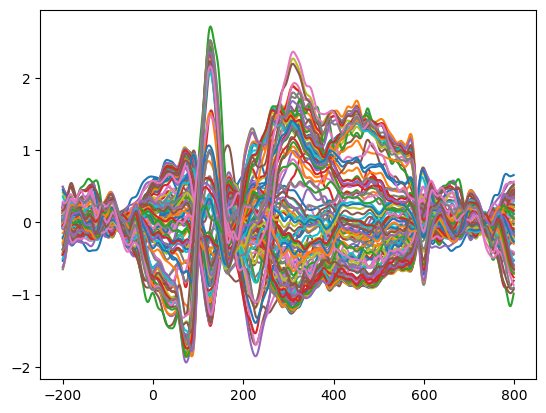

In [9]:
plt.plot(time,erp)
plt.show()

NExt we need an erp by condition, i just do 1 condition for fun here.  

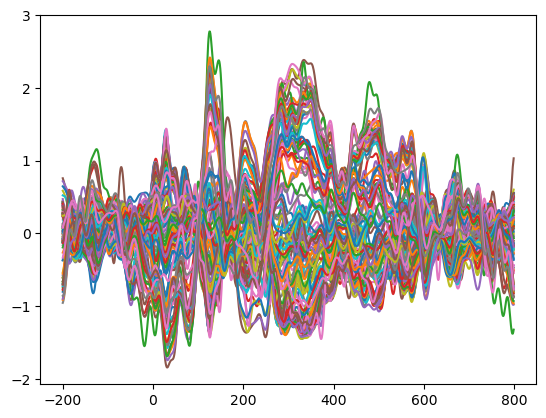

In [10]:
goodstim_1 = np.where(stim_index == 1)[0]
usetrials = np.intersect1d(goodstim_1,good_trials)
erp_1 = np.mean(eeg[usetrials,:,:],axis = 0)
erp_1 = baselinecorrect(erp_1,range(200))
plt.plot(time,erp_1)
plt.show()

Here I compute a singular value decomposition of the overall average erp, limited to a window around the P300 peak.  First I plot the temporal components, and then the spatial component(latter should be replaced by a topo map) 

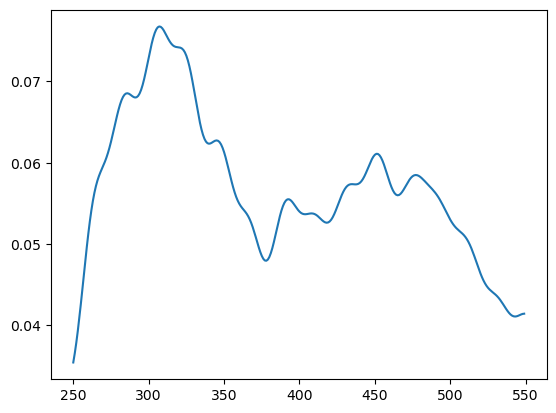

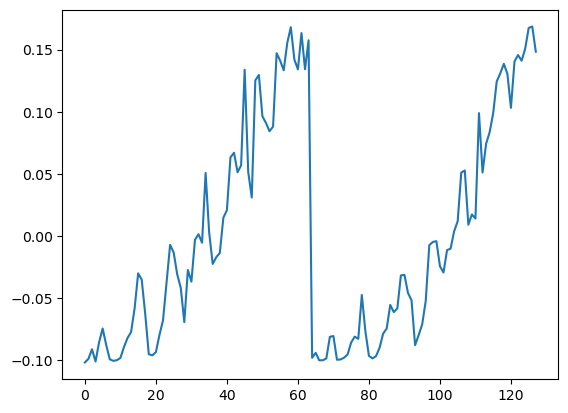

In [11]:
u,s,v = np.linalg.svd(erp[450:750,:])
u = -u
v = -v
plt.plot(time[450:750],u[:,0])
plt.figure()
plt.plot(v[0,:])

here i demonstrate that the temporal component is exactly what you would get if you take the erp and project it along the spatial component by taking a dot product with the spatial compoents  

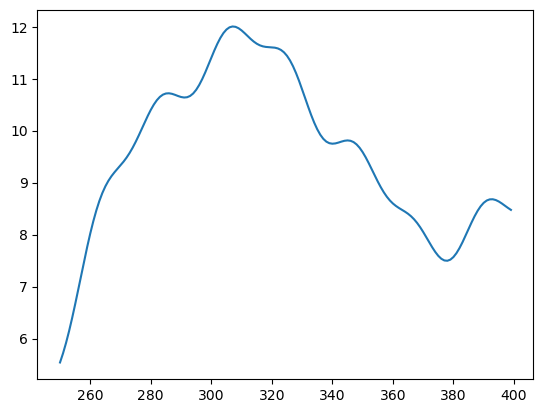

In [12]:
svderp = erp[450:600,:]@np.transpose(v[0,:])
plt.plot(time[450:600],svderp)
plt.show()

Here I show you could in principle use it at all time components, but thats not a good idea really.  you should optimize each erp window.  

In [1]:
x1 = erp@np.transpose(v[0,:])
plt.plot(time,x1)

NameError: name 'erp' is not defined

here i take the erp from one condition, and  project it use the spatial component of all conditions. 

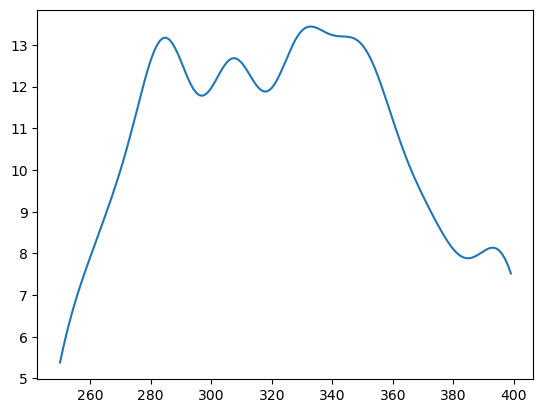

In [14]:
x_c = erp_1[450:600,:]@np.transpose(v[0,:])
plt.plot(time[450:600],x_c)

Here i loop over all features, and make a plot of the P300 effect.  

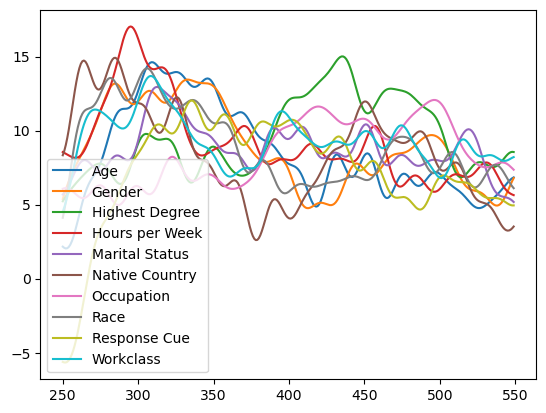

In [15]:
findex = np.where(feature_in_use)[0]
erp_c = np.zeros((1000,10))
for j in range(10):
    goodstim_c = np.where(stim_index == j)[0]
    if take_ends:
        if ses == '1':
            goodstim_c = goodstim_c[np.where(goodstim_c < 500)]
        else:
            goodstim_c = goodstim_c[np.where(goodstim_c >= 1900)]
    usetrials = np.intersect1d(goodstim_c,good_trials)
    temp_erp = np.mean(eeg[usetrials,:,:],axis = 0)
    temp_erp = baselinecorrect(temp_erp,range(200))
    erp_c[:,j] = temp_erp@np.transpose(v[0,:])
plt.figure()
plt.plot(time[450:750],erp_c[450:750,:])
plt.legend(feature_list)

In [16]:
svd_erp = dict()
svd_erp['channel_weights'] = v
svd_erp['temporal_components'] = u
svd_erp['singular values'] = s 
#svd_erp['erp'] = x
svd_erp['erp_by_condition'] = erp_c
svd_erp['condition_labels'] = feature_list
svd_erp['stim_index'] = stim_index
svd_erp['stim_type'] = np.array(stimtype)
svd_erp['stim_val'] = np.array(stimval)
svd_erp['good_trials'] = good_trials
svd_erp['eeg'] = eeg
outpath = f'data/Subject{sub}/{sub}SVD_SS{ses}.hdf'
if take_ends:
    outpath = f'data/Subject{sub}/{sub}SVD_SS{ses}_end50.hdf'
savemat(outpath,svd_erp,store_python_metadata=True)

In [17]:
np.max(erp_c[450:600],axis = 0)

array([14.61994154, 13.44359852, 11.97526437, 17.03054256, 12.94288706,
       14.91383865, 10.27174212, 14.20436338, 12.02751461, 13.68471285])

In [18]:
eeg.shape

(2400, 1000, 128)

In [19]:
usetrials

array([  73,  141,  157,  180,  245,  255,  268,  283,  294,  304,  312,
        334,  352,  365,  377,  385,  396,  404,  415,  426,  431,  444,
        457,  463,  474,  486,  492,  505,  515,  520,  538,  543,  552,
        562,  576,  583,  590,  600,  618,  624,  634,  642,  657,  663,
        675,  686,  694,  700,  718,  725,  734,  740,  758,  763,  776,
        788,  791,  802,  810,  823,  834,  843,  858,  876,  886,  896,
        901,  914,  925,  944,  955,  974,  981,  997, 1007, 1013, 1030,
       1045, 1058, 1063, 1077, 1080, 1092, 1105, 1115, 1120, 1138, 1141,
       1152, 1167, 1171, 1188, 1193, 1205, 1213, 1222, 1234, 1248, 1254,
       1266, 1271, 1281, 1292, 1307, 1315, 1321, 1338, 1348, 1357, 1364,
       1373, 1388, 1394, 1405, 1415, 1422, 1430, 1447, 1457, 1464, 1476,
       1487, 1498, 1508, 1517, 1524, 1536, 1544, 1557, 1563, 1572, 1580,
       1595, 1604, 1618, 1624, 1634, 1647, 1650, 1663, 1686, 1690, 1703,
       1714, 1727, 1736, 1746, 1758, 1767, 1772, 17

In [20]:
eeg.shape

(2400, 1000, 128)

In [21]:
stim_index[good_trials]

array([3., 7., 1., ..., 0., 1., 2.])

In [22]:
good_trials

array([   6,   13,   15, ..., 2396, 2397, 2398])